# MODA Tutorial for TTTA prediction:

---

**Abstract:** *In this notebook you will find how the analyses and protocol used to predict magnetic exchange couplings, $J_{AB}$, using the Molecular Orbital Decomposition and Aggregation (MODA), but it can be further extended to SOAP and BoB. The notebook covers most of the topics discussed in the article in a tutorial-like style. Here, we use a reduced version of the TTTA dataset as a toy example, consisting of 400 equidistant samples of a TTTA pair from the HT polymorph extracted from an AIMD simulation at 300K, that is referred as HT-300K simulation in the article. These samples range from 0 to 2ps of AIMD and have been specially selected as a representative subset of the overall evolution of $J_{AB}$ in larger simulation runs.* 

---

**Contents:**

1. Importing the Modules
2. Reading and visualizing the dataset
3. Calculating MODA features
4. Visualizing intra- and intermolecular MODA features
5. Usaging MODA for ML applications and kernel methods:
    1. Computation and visualization of intra- and intermolecular RBF kernel
    2. Unsuperised Learning: Agglomerative Clustering
    3. Supervised Learning: Kernel Ridge Regression
        1. The simplest experiment: identity plot
        2. Full Learning Curve
6. Final remarks

# 1. Importing the Modules:
In order to execute and experiment with this notebook we use some specific modules. Some of them are "general-purpose" modules such as `numpy`, `scipy` and `matplotlib`. Moreover, we use Atomic Simulation Environment (`ase`) to read and parse molecular structures and `sklearn` for both supervised and unsupervised ML tasks. Finally, we can use our implementation of MODA, SOAP and BoB (among some other tools related to that) grouped in a code snippet in the form of module (Cool Machine Learning for Molecules, a.k.a. `MLcool`). 

---

**Note:**
Make sure you have all the dependencies installed before executing any cell. Check the requirements file in the repository.

In [11]:
# General purpose modules:
# ----------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Molecular structure:
# ----------------------------------------------------------------
from ase.io import read
from ase.visualize import view
import nglview # visualization of ASE objects embedded in the notebook's HTML

# MLcool module:
# ----------------------------------------------------------------
from MLcool import Molecule
from MLcool.utils.general_tools import get_monomers
from MLcool.learning.kernels import Normalize, SimpleKernel

# sk-learn
# ----------------------------------------------------------------
from sklearn.cluster import AgglomerativeClustering
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as R2

# 2. Reading and Visualizing the dataset:
As mentioned before, this tutorial makes use of $J_{AB}$ values from TTTA pairs obtained from DFT calculations. We use 400 samples from the begining of the AIMD to 2ps (*i.e.* samples are selected every 5 steps within the 0-2000 interval). We allocate the precomputed $J_{AB}$ values in `target` and read the TTTA dimer structure in `samples` using `read()` function of `ase` package, which returns the main `Atoms()` instance. The variable `x` is used as a placeholder to indicate the index of the samples according to the original AIMD index (0, 5, 10, ..., 1995).

---

We can view the AIMD trajectory of the TTTA samples using `nglview.show_asetraj()` and plot the $J_{AB}$ values by defining `plot_raw_data()` function. The $J_{AB}$ values remain under $-500cm^{-1}$ for the most part, but these suffer a drastic drop to $-4000cm^{-1}$ at the interval $S_{drop}\in(1000,1500)$. An inspection of the monomers conformation at $S_{drop}$ shows that the TTTA monomers have got **slightly** closer and, thus, the overlap between the TTTA singly-occupied natural orbitals (SONOs) has **drastically** increased. This uncovers the high sensitivity of $J_{AB}$ to small structural changes, which is a fundamental source of complexity of this dataset.

---

**Note:**
- Make sure that `path`, `couplings_path` and `xyz_path` are compatible with your local folder structure.
- It is possible that the preview of this notebook does not show the cell execution of `nglview.show_asetraj(samples, gui=True)`. If that is the case, consider to substitute this line with `view(samples, viewer='ase')`.

In [12]:
# ----------------------------------------------------------------
# Read J_{AB} and samples:
# ----------------------------------------------------------------

path           = './DB/STRUCTURE_AND_DFT/TTTA/'
couplings_path = path + 'couplings/HT-D1C1.dat'
xyz_path       = path + 'XYZ/HT-D1C1/STEP{}.xyz'

ini, fin, step = 0, 2000, 5 # 400 samples, (fin-ini)/(step-1) = (2000-0)/(5-1) = 400

target         = np.loadtxt(couplings_path)[ini:fin:step]
n_samples      = target.shape[0]
x              = np.arange(ini, fin, step)
samples        = [read(xyz_path.format(int(i+1))) for i in x]

In [13]:
# ----------------------------------------------------------------
# View samples:
# ----------------------------------------------------------------

nglview.show_asetraj(samples, gui=True)

NGLWidget(max_frame=399)

In [14]:
def plot_raw_data(x, y):
    fig, ax = plt.subplots(1, figsize=(5.5,3.5))

    ax.plot(x, y, lw=2, label='target')
    ax.axhline(y=0.0, color='red', ls='--', lw=2, label=r'$J_{AB} = 0$')
    ax.grid(ls='--', lw=1, alpha=0.4)
    ax.set_xlabel(r'Sample Index (S)')
    ax.set_ylabel(r'Target property ($J_{AB}$ in $cm^{-1}$)')

    plt.legend()
    plt.tight_layout()
    
    return fig, ax

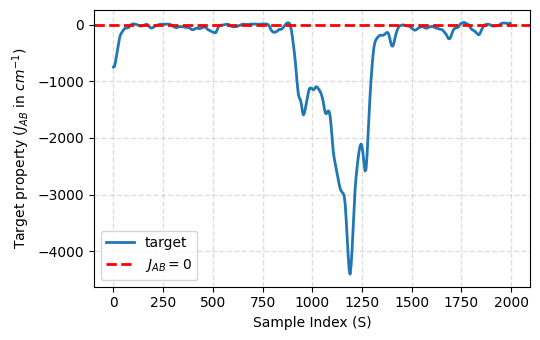

In [15]:
# ----------------------------------------------------------------
# Plot J_{AB} values:
# ----------------------------------------------------------------

fig, ax = plot_raw_data(x, target)
plt.show()

# 3. Calculating MODA features:
The first step in ML applications to chemistry might be to transform the data structure into a descriptor. As we stress in the article, MODA is a optimal choice that combines QIR with intermolecular separability. Let us transform our previously read `samples` into MODA representation.

---

We begin by defining the function `calculate_moda()` that takes `samples` as an argument and return two arrays: `labels` and `features`. The function internally splits each configuration of the dimer (`s` inside the loop) into two monomers (`monomer1` and `monomer2`). Then, it instanciates a class of type `MLcool.Molecule()` for each monomer, which is the core object to calculate MODA with our implementation. After that, the method `solve_H()` computes the superposition of atomic densities (SAD) matrix normally used as an starting point for SCF calculations, and perform a Lowdin's diagonalization of the density matrix to internally obtain the natural orbitals and the occupation. The next step is to add both monomers. This task simply reduces to a "`+`" operation, as the dunder `__add__()` method has been redefined in `Molecule()`. This method performs the linear combination of **molecular** (not atomic) orbitals to obtain an approximate representation of the dimer orbitals. Finally, we can obtain the MODA representation of the TTTA dimer using `get_MODA()` method. 

It is important to note that `calculate_moda()` also requires another argument, that is, `basis`, which specifies the basis set used in the representation. This is a key aspect and can be even considered an *hyperparameter* of the MODA descriptor. In the example bellow we use an small STO-3G and a larger 6-31+G* basis set to show the differences between them. Indeed, the latter corresponds to the basis set used to carry out the DFT calculations of $J_{AB}$ for the TTTA dataset in the first place.

---

**Note:**
- `Molecule()` allows to set the `spin` and `charge` of the chemical system in its constructor. We have set these parameter to 1 and 0, respectively, in order to consider the electronic structure of the neutral TTTA radicals.
- MODA representation allows to consider a subset of orbitals in the representation. Only the SONOs of the `dimer` have been included in the representation for the purpose of $J_{AB}$ prediction. This can be achieved by setting `orbital_numbers = [dimer.noccupied-2, dimer.noccupied-1]` in `get_MODA()`.
- As mentioned before, MODA representation allows to intra/intermolecular decoupling. Setting `intermolecular = True` in `get_MODA()` allows this behaviour to take place.
- MODA requires SAD guess and Lowdin diagonalization to obtain the natural orbitals. The computational cost of this process is optimized by using `pyscf` in the backend, but still can take a while depending on the size and basis set of choice.
- After the `calculate_moda()` call, a `MLcool.Normalizer()` instance is used to normalize intra/intermolecular components separately. This is a typical procedure in ML applications to enhance fitting and training of ML models. The final MODA features are saved in the variable `features_{basis}_norm`, where `{basis}` is a placeholder for the basis set employed (either big or small for STO-3G and 6-31+G*, respectively).

In [16]:
def calculate_moda(samples, basis='6-31+G*'): 
    print('-'*40)
    print('>  (!) CALCULATING MODA (!)')
    
    features = []
    for i, s in enumerate(samples):

        # Extract the monomers from the dimer conformation:
        (monomer1, monomer2), connectivity = get_monomers(s, 2.0, verbose = False)

        # Transform the Atoms() object to Molecule()
        monomer1 = Molecule(monomer1, spin=1, charge=0, basis=basis)
        monomer2 = Molecule(monomer2, spin=1, charge=0, basis=basis)

        # Calculate SAD guess and get Natural Orbitals (NO)
        monomer1.solve_H()
        monomer2.solve_H()

        # Sum the two representations:
        dimer = monomer1 + monomer2

        # Get MODA of the dimer with intra- and inter terms decoupled:
        labels, values = dimer.get_MODA(
            orbital_numbers = [dimer.noccupied-2, dimer.noccupied-1],
            intermolecular  = True,
            connectivity    = connectivity,
            verbose         = False
        )

        features.append(values)

        print(f'>> Step {i+1:10}/{n_samples} ...', end = '\r')
        
    print()
    print('>  DONE')
    print('-'*40)

    return labels, np.array(features)

In [17]:
# ----------------------------------------------------------------
# Calculation of MODA with SMALL basis set (STO-3G):
# ----------------------------------------------------------------

labels_small, features_small = calculate_moda(samples, basis='STO-3G')
normalizer                   = Normalize()
features_small_norm          = normalizer.fit_transform(features_small)

----------------------------------------
>  (!) CALCULATING MODA (!)
>> Step        400/400 ...
>  DONE
----------------------------------------


In [18]:
# ----------------------------------------------------------------
# Calculation of MODA with BIG basis set (6-31+G*):
# ----------------------------------------------------------------

labels_big, features_big = calculate_moda(samples, basis='6-31+G*')
normalizer               = Normalize()
features_big_norm        = normalizer.fit_transform(features_big)

----------------------------------------
>  (!) CALCULATING MODA (!)
>> Step        400/400 ...
>  DONE
----------------------------------------


# 4. Visualizing intra- and intermolecular MODA features:

We can visualize the intra- and intermolecular components after normalization together with the $J_{AB}$ evolution. As $J_{AB}$ of TTTA pairs is an intermolecular property, we expect to observe correlation between intermolecular MODA components and the target property, while intramolecular components should show no correlation at all. Moreover, this visual inspection may shed some light in the potential performance of MODA using two different basis sets.

---

For this purpose we can define the function `plot_features()`. This function immediatly pops up 3 plots. The first one corresponds to intramolecular components. Next, the intermolecular components and, finally, the $J_{AB}$ values (included for comparison to the rest of the plots). The first two plots contain a set of different curves, each of them corresponding to the evolution of a certain component of MODA. For example, a given curve may correspond to the interaction of $3p$ orbitals between $S-S$ atoms, while another can be $1s-2s$ interaction between $C-N$ atoms. The cells below execute the code devoted to create this set of plots using small and big basis sets. Regardless of the choice, it is clear  that the intramolecular components do not correlate at all with the $J_{AB}$ evolution along the subset of AIMD, while these show a great correlation with the intermolecular components along the whole range. Another characteristic feature is that many of the curves present on the plots are zero along the samples. These correspond to the interactions between core levels, which do not contribute to the SONOs selected for the representation. 

---

There can be observed two fundamental differences between the plots of MODA components using small and big basis sets: 
1. As the number of basis functions is smaller for STO-3G than in 6-31+G*, the number of components in the representation is also smaller and, thus, the number of curves plotted is hence smaller. For example, the component indicating the interaction of $3d$ orbitals between $S-S$ atoms is not present in the STO-3G case, as $3d$ orbitals of $S$ atoms are not included in the basis set. 
2. The sensitivity of the descriptor evolution, that is, the change induced in the descriptor due to a small change in the original molecular structure, is much larger in 6-31+G* basis set than in STO-3G. In a nutshell, 6-31+G* basis set possesses much more diffuse GTOs and, thus, their ratio of decay is much larger. This make two GTOs centered at different atoms to have a non-null overlap at long distances and have a larger sensitivity in this range.  

---

**Note:**
Try to plot the features before normalization and see the ranges spanned by both intra- and intermolecular components and note that intramolecular components lay in several orders of magnitude higher compared to intermolecular ones. Change `features_big_norm` by `features_big` in `fig, ax = plot_features(x, features_big_norm, target, labels=None)`. This exercise may bring some insights on the importance of normalization.

In [19]:
def plot_features(x_coord, features, target, labels=None, scale=False):
    fig, axes     = plt.subplots(3,sharex=True,figsize=(5.5,6.5))
    ax1, ax2, ax3 = axes
    
    intra_feat    = features[:,0,:].T.copy()
    inter_feat    = features[:,1,:].T.copy()
    
    for i, (curve_intra, curve_inter) in enumerate(zip(intra_feat, inter_feat)):
        lab = labels[i] if labels is not None else labels
        ax1.plot(x_coord, curve_intra if not scale else curve_intra - np.mean(curve_intra), lw=2, label=lab)
        ax2.plot(x_coord, curve_inter if not scale else curve_inter - np.mean(curve_inter), lw=2, label=lab)
        
    if labels is not None: ax1.legend()
    
    ax3.plot(x_coord,target, lw = 2)
    ax3.axhline(y=0.0, color='red', ls='--', lw=2, label='origin')
    
    inc = 0.5
    for ax in axes:
        ax.grid(alpha = 0.3, lw = 1, ls = '--')
        ax.set_xlim([x_coord[0]-inc,x_coord[-1]+inc])
        
    ax1.set_ylabel(r'Intra. Components')
    ax2.set_ylabel(r'Inter. Components')
    ax3.set_xlabel(r'Sample Index (S)')
    ax3.set_ylabel(r'Target ($J_{AB}$) $cm^{-1}$')
    
    plt.subplots_adjust(left=0.1, bottom=0.08, right=0.99, top=0.99, wspace=None, hspace=0)
    
    return fig, axes

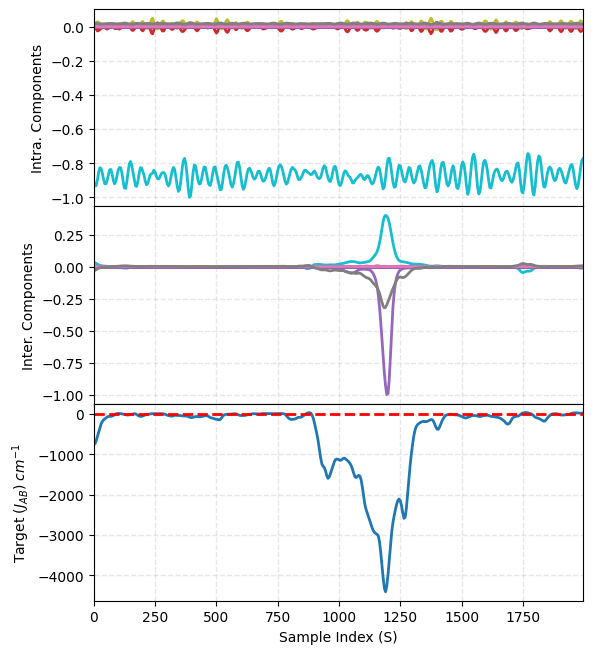

In [20]:
# ----------------------------------------------------------------
# Representation of MODA components with SMALL basis set (STO-3G):
# ----------------------------------------------------------------

fig, ax = plot_features(x, features_small_norm, target, labels=None)
plt.show()

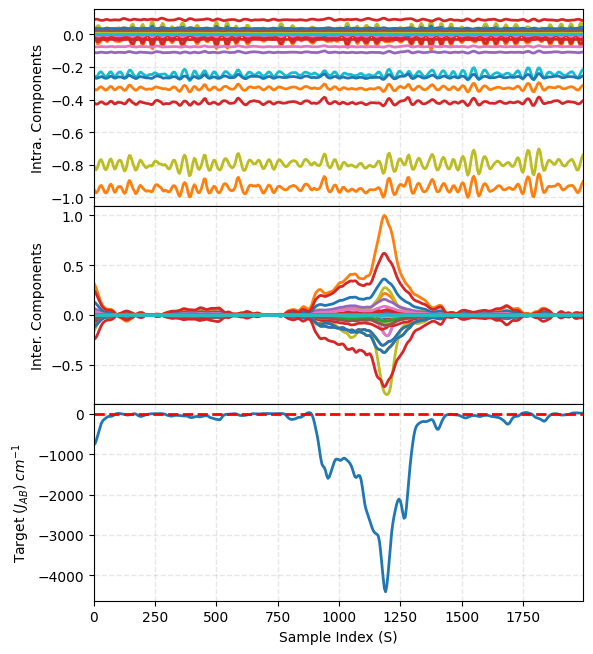

In [21]:
# ----------------------------------------------------------------
# Representation of MODA components with BIG basis set (6-31+G*):
# ----------------------------------------------------------------

fig, ax = plot_features(x, features_big_norm, target, labels=None)
plt.show()

# 5) Usaing of MODA for ML applications and kernel methods:
We have calculated MODA features separating intra- and intermolecular components. Now, we can use them in different ML applications. The scope of this tutorial is not to seek for the optimal learning model for $J_{AB}$ predictions. Instead, we aim to ilustrate MODA in both unsupervised and supervised tasks. For the sake of generality, in both cases we use non-linear methods that employ some non-linear similarity/distance metric to for fitting purposes and make predictions: **Agglomerative Clustering** (AC, unsupervised) and **Kernel Ridge Regression** (KRR, supervised).

## A) Computation and visualization of intra- and intermolecular RBF kernel:
A common source of non-linearity are radial basis functions (RBF). The RBF kernel function is defined as:

$$\kappa(s_k,s_l;\gamma) = e^{-\gamma(s_k-s_l)^2}$$

where $s_i$ is the vector representation of samples $i$, and $\gamma$ is a hyperparameter controlling the radial decay of the kernel. Our implementation of the RBF kernel (the class `SimpleKernel()`) allows to decouple intra- and intermolecular components in order to add flexibility to the final sample-sample distance. This is achieved by allowing separate regularization for the different components ($\gamma^I$ and $\gamma^i$ for intra- and intermolecular components, respectively). More precisely, our RBF definition becomes:

$$\kappa(s_k,s_l;\gamma^I,\gamma^i) = e^{-\gamma^I(s_k-s_l)^2_{intra}}e^{-\gamma^i(s_k-s_l)^2_{inter}}$$

The choice of the touple $(\gamma^I,\gamma^i)$ is fundamental for the performance of a given model trained upon the RBF metric: by letting  $\gamma^I \rightarrow 0$ we force the function to neglect the intramolecular components, while letting $\gamma^i \rightarrow 0$ produce the opposite effect. Moreover, setting $\gamma^k \rightarrow \infty$ makes the RBF kernel to tend to a Dirac delta function centered at zero, which implies that a given data sample is only similar to itself and orthogonal to the rest. 

For a set of $N$ samples, $S = \{s_k\}_{k=1,N}$, we can compute the RBF kernel for each pair, yielding a `kernel` matrix of `kernel.shape = (N,N)`. The components of this matrix (similarity maps) are the fundamental objects to fit both AC and KRR and, thus, its qualitative inspection can give us key insights to understand how the final model would perform before investing too much time in its train/test and validation.

---

Here we show some experiments: we use both our small and big basis sets to assess their effect on the shape of the kernel. Moreover, we can tune the values of $(\gamma^I,\gamma^i)$ to explore the effect of intra- and intermolecular components to the kernel. In line with this, we define `gamma_intra_only = np.power(10,[+1.,-100])` that sets $\gamma^I$ to a reasonable value of $10$ and $\gamma^i$ to $10^{-100} \rightarrow 0$. On the other hand, we also define `gamma_inter_only = np.power(10,[-100.,+1])` that correspond to the opposite situation (only intermolecular effects). We can define the function `plot_kernel()` to visualize the `kernel_{basis}_{extreme}` matrix in each case, where `{extreme}` is a placeholder for `intra` or `inter`.

---

From the results of the experiments stated above, it is clear that intramolecular-only kernels (despite of the basis set used) produce similarity maps that do not reproduce the evolution of $J_{AB}$ along the range explored. Thus, the potential ML model would be informed with similarity data that do not reflect the correct similarity between data samples. On the other hand, intermolecular-only kernel with an small basis set produces an "extreme" kernel, where all the data samples with $J_{AB}$ close to $0$ have a similarity of $1$. In conclusion, 6-31+G* basis set with intermolecular-only kernel is the only combination able to capture the correlation of the data samples and the target $J_{AB}$ smoothly enough.

---

**Note:** 
- in our implementation of the RBF kernel (`SimpleKernel`), the computationally-heavy steps are transpiled from a compiled `fortran` subroutine and generalized for parallel computing, which makes it much more efficient for large datasets. Let us stress that `kernel` is a symmetric matrix with values of $1$ for diagonal entries. Thus, for $N$ samples, the minimum number of components needed for its computation is either the upper or lower triangular regions, which are $N(N-1)/2 \propto N^2$, that can easily become the bottleneck of the fitting procedure for many ML models.
- The resulting figure from `plot_kernel()` incorporates the $J_{AB}$ value evolution in both x- and y-axis. It is worth to mention that $J_{AB}$ values are not used to compute the `kernel`, but these are only included as a guide to the eye to easily match each structure to a given $J_{AB}$.
- The choice of $(\gamma^I,\gamma^i)$ in these examples is arbitrary. In order to obtain precise results many values of $\gamma$ parameters should be tested.

In [22]:
def plot_kernel(kernel, features, target):
    fig = plt.figure(figsize=(4,4))
    
    target_h = 6
    kernel_h = 16
    tot_size = target_h + kernel_h
    
    mn, mx, st  = 0, len(target), 1
    x           = np.arange(mn, mx, st)
    
    grid        = gridspec.GridSpec(tot_size, tot_size, hspace=0.01, wspace=0.01)
    ax_kr       = fig.add_subplot(grid[target_h:, target_h:])
    ax_tar_l    = fig.add_subplot(grid[target_h:, :target_h])
    ax_tar_b    = fig.add_subplot(grid[:target_h, target_h:])
    axs         = (ax_kr, ax_tar_l, ax_tar_b)
    
    ax_tar_l.plot(target, x, c ='#cf132f', lw=2)
    ax_tar_l.axvline(x=0.0, color='#3c4045', ls='--', lw=2, label='origin', alpha=0.4)
    
    ax_tar_b.plot(x,-target, c ='#cf132f', lw=2)
    ax_tar_b.axhline(y=0.0, color='#3c4045', ls='--', lw=2, label='origin', alpha=0.4)
    
    im = ax_kr.imshow(kernel, aspect='auto', cmap='viridis', interpolation='gaussian', vmin=0, vmax=1)
    
    ax_tar_l.set_ylim(mx, mn)
    ax_tar_b.set_xlim(mn, mx)
    
    ax_tar_l.axis('off')
    ax_tar_b.axis('off')
    ax_kr.axis('off')

    cbar_ax = fig.add_axes([0.1, 0.7, 0.02, 0.2])
    fig.colorbar(im, cax = cbar_ax)
    
    plt.subplots_adjust(left=0.01, bottom=0.01, right=0.99, top=0.99, wspace=0, hspace=0)
    
    return fig, axs

In [23]:
# ----------------------------------------------------------------
# Prepare the kernel experiments:
# ----------------------------------------------------------------

gamma_intra = np.power(10,[+1.,-100]) # (gamma_intra, gamma_inter)
gamma_inter = np.power(10,[-100.,+1]) # (gamma_intra, gamma_inter)

rbf_intra     = SimpleKernel(gamma_intra, 'rbf')
rbf_inter     = SimpleKernel(gamma_inter, 'rbf')

# ----------------------------------------------------------------
# Compute the kernels:
# ----------------------------------------------------------------

# n_jobs = -1 allows to use all the threads available in the computer.
kernel_small_intra  = rbf_intra.get(features_small_norm, n_jobs = -1)
kernel_small_inter  = rbf_inter.get(features_small_norm, n_jobs = -1)

kernel_big_intra  = rbf_intra.get(features_big_norm, n_jobs = -1)
kernel_big_inter  = rbf_inter.get(features_big_norm, n_jobs = -1)

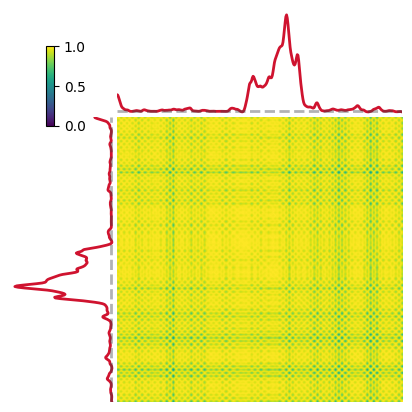

In [24]:
# ----------------------------------------------------------------
# RBF Kernel with MODA components with SMALL basis set (STO-3G) and INTRAmolecular-only kernel:
# ----------------------------------------------------------------

fig, ax = plot_kernel(kernel_small_intra, features_small, target)
plt.show()

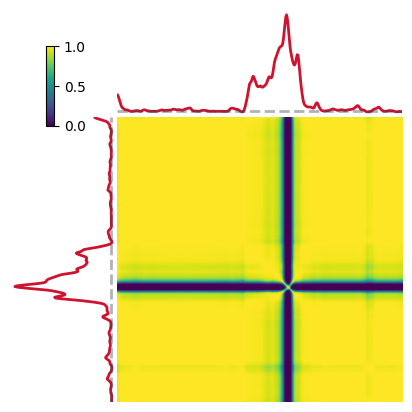

In [25]:
# ----------------------------------------------------------------
# RBF Kernel with MODA components with SMALL basis set (STO-3G) and INTERmolecular-only kernel:
# ----------------------------------------------------------------

fig, ax = plot_kernel(kernel_small_inter, features_small, target)
plt.show()

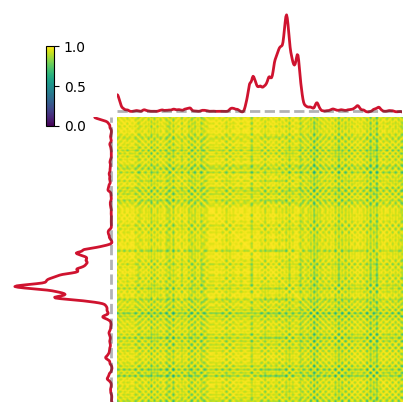

In [26]:
# ----------------------------------------------------------------
# RBF Kernel with MODA components with BIG basis set (6-31+G*) and INTRAmolecular-only kernel:
# ----------------------------------------------------------------

fig, ax = plot_kernel(kernel_big_intra, features_big, target)
plt.show()

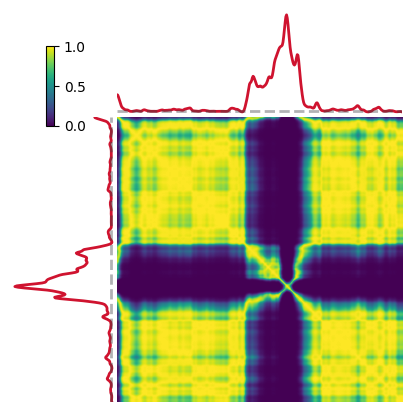

In [27]:
# ----------------------------------------------------------------
# RBF Kernel with MODA components with BIG basis set (6-31+G*) and INTERmolecular-only kernel:
# ----------------------------------------------------------------

fig, ax = plot_kernel(kernel_big_inter, features_big, target)
plt.show()

## B) Unsupervised Learning: Agglomerative Clustering

We can use the formerly produced RBF kernels to fit a simple Agglomerative Clustering (AC) model. AC uses distance maps instead of similarity maps, which can be obtained via:  $d = \hat{1} - \kappa$, where $d$ is the distance matrix and $\hat{1}$ is a matrix of a compatible dimension where all its entrances are one.

---

In this example we fit the `AgglomerativeClustering()` model from `sklearn` using intra/intermolecular-only kernels with 6-31+G* basis set (`kernel_big_inter` and `kernel_big_intra`). `AgglomerativeClustering()` requires to pre-set the number of clusters that the samples are collapsed in. In this case, we have set `n_clusters = 5`, but many other choices are also valid. We can define the `plot_clusters()` function to project the clusters to the $J_{AB}$ profile and observe the clustering patern in both cases. 

It is clear from the plot that the kernel produced by intermolecular features of MODA representation properly group the data samples according to the $J_{AB}$ value, that is, it appears a clustering pattern compatible with the distribution of $J_{AB}$. In contrast, the clustering patern produced by the intramolecular-only kernel is completely erratic and shows a clear lack of order or sense. For this reason, we consider demonstrated the importance of intra/intermolecular decoupling and this set of preliminary analyses before fitting any other sophysticated yet time-consuming supervised ML model.

---

**Note:**
The color code for the clusters are arbitrary and are meaningless (!)


In [28]:
def plot_clusters(x, target, clusters):
    fig, ax = plt.subplots(1, figsize=(5.5,3.5))
    
    ax.plot(x, target, color = 'black', alpha = 0.5, zorder = 1)
    ax.axhline(y=0.0, color='red', ls='--', lw=2, label=r'$J_{AB} = 0$', zorder=3)
    ax.grid(ls='--', lw=1, alpha=0.4)
    ax.set_xlabel(r'Sample Index (S)')
    ax.set_ylabel(r'Target property ($J_{AB}$ in $cm^{-1}$)')
    
    ax.scatter(x, target, c=clusters, zorder = 2)
    plt.tight_layout()
    
    return fig, ax

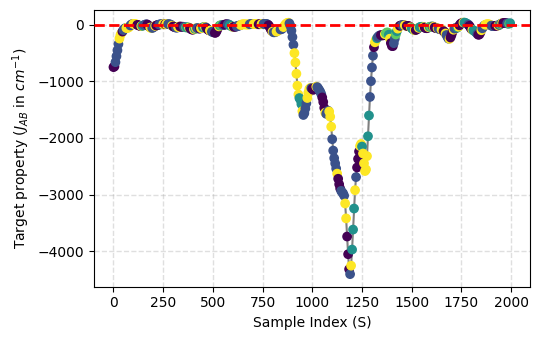

In [29]:
# ----------------------------------------------------------------
# Clusters for RBF Kernel with MODA components with BIG basis set (6-31+G*) and INTRAmolecular-only kernel:
# ----------------------------------------------------------------

clusters = AgglomerativeClustering(
    n_clusters = 5,
    metric = 'precomputed',
    linkage='complete'
)

clusters_big_intra = clusters.fit_predict(1-kernel_big_intra)
fig, ax            = plot_clusters(x, target, clusters_big_intra)
plt.show()

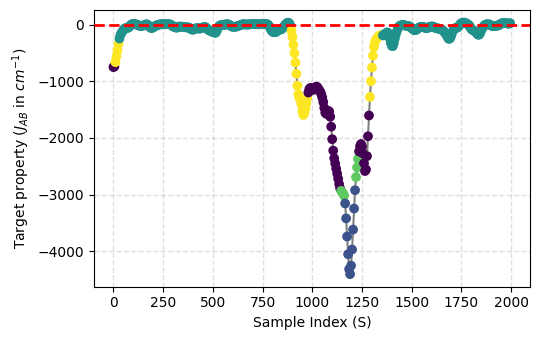

In [30]:
# ----------------------------------------------------------------
# Clusters for RBF Kernel with MODA components with BIG basis set (6-31+G*) and INTERmolecular-only kernel:
# ----------------------------------------------------------------

clusters = AgglomerativeClustering(
    n_clusters = 5,
    metric = 'precomputed',
    linkage='complete'
)

clusters_big_inter = clusters.fit_predict(1-kernel_big_inter)
fig, ax            = plot_clusters(x, target, clusters_big_inter)
plt.show()

# C) Supervised Learning: Kernel Ridge Regression
The previous analyses show how to get MODA from a set of structures. Moreover, we have assessed the effect of the basis set *hyperparameter* and intra/intermolecular decoupling. We concluded that a diffuse basis set and decoupling the components is critical to get adequate kernels. Finally, we have tested our findings evaluating the performance by fitting an unsupervised AC model to observe the clustering patterns. Now, we can use the best representation to fit a KRR model, which also uses similarity maps (RBF kernel in our case) as a fundamental tool.

### a) The simplest experiment: identity plot
In this subsection we manually tune the $\gamma^i$ hyperparameter while keeping $\gamma^I \rightarrow 0$. The first experiment consists on choosing a fixed amount of training data to fit the KRR model and, subsequently, predict the remaining $J_{AB}$ values of the training split. For example, we can randomly select $70\%$ of the data for training and evaluate on the remaining $30\%$. Then, we can represent the $J_{DFT}$ *vs.* $J_{predict}$ curve, which is usually referred as the identity plot. After that, we calculate the error based on Mean Absolut Error (MAE) and $R^2$ metrics. If the model performance is good enough, $J_{DFT}$ should be equal (or close enough) to $J_{predict}$, resulting in the identity function ($y=x$). Moreover, MAE and $R^2$ should approach to $0$ and $1$, respectively.

---

We define `krr_prediction()` function that performs the following steps: 
1. Takes MODA representation and $J_{AB}$ values (`features_big_norm`, `target`)
2. Accordingly to the amount of training data selected (`perc_train`) it splits the data in train and test after shuffleing the samples (`features_tr`, `features_ts` and `target_tr`, `target_ts`).
3. Calculates the RBF kernel according to some pre-set `gamma` for both splits.
4. Initializes the KRR model via the class `KernelRidge()` of `sklearn` (`model` variable).
5. Fits the model and computes the predictions via `fit()` and `predict()` methods.
6. Finally, the targets and predictions are returned for both training and test splits.

After that, we can define the function `plot_identity()` to visualize the identity plot and compute the error metrics via `get_metrics()`.

---

While fixing the trainig set size to $70\%$ we can explore different values of $\gamma^i$. In this case we have tested three different values: `1e-10`, `1e-1`and `1e+2`. It is clear from a qualitative inspection that the intermediate value (`1e-1`) approaches better to the ideal $x=y$ identity trend. Moreover, this can be quantitatively evaluated, as both MAE and $R^2$ approach to $0$ and $1$ respectively in this case.

---

**Note:** The hyperparameter $\gamma$ has been naively tunned in this example. Other techniques such as cross-validation along many other $\gamma$ values should be used for a fine-tunned model. However, this is out of the scope of this tutorial.

In [31]:
def krr_prediction(features, target, perc_train, gamma, alpha):
    all_index   = np.arange(len(target))
    np.random.shuffle(all_index)
    
    limit_train = int(perc_train*n_samples)
    tr_index    = all_index[:limit_train]
    ts_index    = all_index[limit_train:]
    
    features_tr = features[tr_index]
    features_ts = features[ts_index]

    target_tr   = target[tr_index]
    target_ts   = target[ts_index]
    
    rbf         = SimpleKernel(gamma, 'rbf')
    kernel_tr   = rbf.get(features_tr, n_jobs = -1)
    kernel_ts   = rbf.get(features_tr, features_ts, n_jobs = -1)
    
    model       = KernelRidge(kernel='precomputed', alpha=alpha)
    model       = model.fit(kernel_tr, target_tr)
    
    pred_tr     = model.predict(kernel_tr)
    pred_ts     = model.predict(kernel_ts)
    
    return (target_tr, pred_tr), (target_ts, pred_ts)


def get_metrics(target, pred): 
    return MAE(target, pred), R2(target, pred)


def plot_identity(target, prediction, perc_train, gamma):
    fig, ax = plt.subplots(1, figsize=(5.5,3.5))
    
    ax.scatter(target, prediction, s=15, alpha=0.8, zorder=2)
    ax.plot(target, target, color='red', zorder=1)
    
    ax.set_xlabel(r'DFT ($J_{AB}$ in $cm^{-1}$)')
    ax.set_ylabel(r'KRR Prediction ($J_{AB}$ in $cm^{-1}$)')
    
    plot_title = 'train size={:.2f}%, MAE={:.2f}, R^2={:.4f}, '.format(100*perc_train,*get_metrics(target,prediction))
    plot_title += r'$log(\gamma^i)$=' + '{:.3f}'.format(np.log10(gamma[-1]))
    ax.set_title(plot_title)
    
    ax.grid(ls='--', lw=1, alpha=0.4)
    plt.tight_layout()
    
    return fig, ax

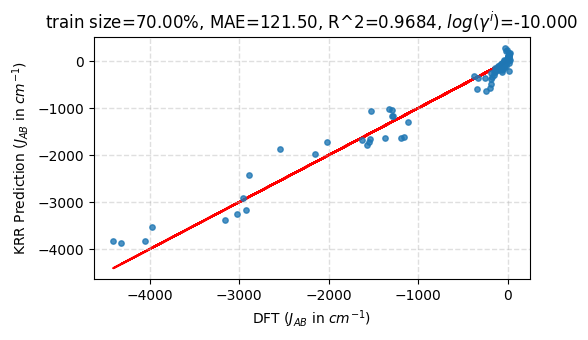

In [32]:
# ----------------------------------------------------------------
# Identity plot in where \gamma^i = 1e-10
# ----------------------------------------------------------------

gamma                  = np.power(10,[-100,-10.])
perc_train             = 0.70
tr_targets, ts_targets = krr_prediction(features_big_norm, target, perc_train=perc_train, gamma=gamma, alpha=1e-10)

fig, ax = plot_identity(ts_targets[0], ts_targets[1], perc_train, gamma)
plt.show()

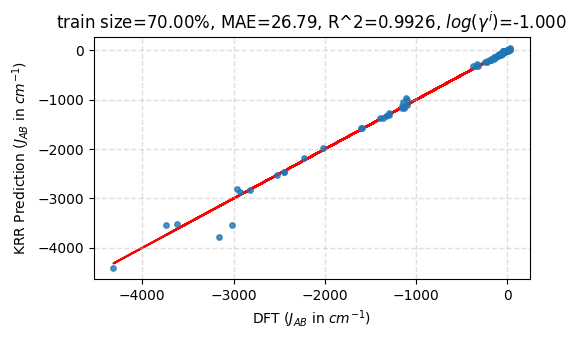

In [33]:
# ----------------------------------------------------------------
# Identity plot in where \gamma^i = 1e-1
# ----------------------------------------------------------------

gamma                  = np.power(10,[-100,-1.])
perc_train             = 0.70
tr_targets, ts_targets = krr_prediction(features_big_norm, target, perc_train=perc_train, gamma=gamma, alpha=1e-10)

fig, ax = plot_identity(ts_targets[0], ts_targets[1], perc_train, gamma)
plt.show()

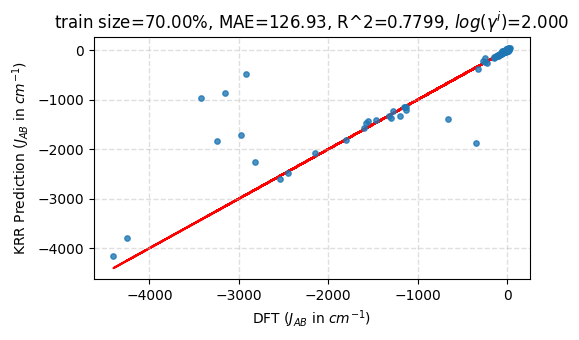

In [34]:
# ----------------------------------------------------------------
# Identity plot in where \gamma^i = 1e+2
# ----------------------------------------------------------------

gamma                  = np.power(10,[-100,+2.])
perc_train             = 0.70
tr_targets, ts_targets = krr_prediction(features_big_norm, target, perc_train=perc_train, gamma=gamma, alpha=1e-10)

fig, ax = plot_identity(ts_targets[0], ts_targets[1], perc_train, gamma)
plt.show()

### b) Full Learning Curve
We can do a further step by fixing the *optimal* value of $\gamma$ and evaluate the performance of the model while increasing the amount of data used for train/testing, which is usually called a learning curve. We can define `learning_curve()` function to automatize this process, which repeatedly calculate the error metrics via `krr_prediction()` for different amounts of data.

As the data devoted to train or test is randomly selected every time `krr_prediction()`, it is statistically possible to randomly pick non-representative or redundant data to train. Thus, the model could be forced to extrapolate too much and produce incorrect results. In order to solve that, we can compute many learning curves to calculate a statistically significant mean value of the error metric.

---

We show the learning curve obtained when $200$ fractions of training sizes from $20\%$ to $95\%$ are selected as the learning curve range, and repeated this process $30$ times to get a statistical mean values for MAE. We can also use the *optimal* value of $\gamma$ we have found so far. We can define `plot_learning_curve()` to represent the mean value of the MAE and its associated statistical deviation. The results show that the MAE saturate around $60\%$, which indicates that this amount of data is enough to fit a model able to generalize the representation and, thus, able to interpolate and extrapolate the unseen $40\%$ of data samples. 

---

**Note:**
- The datatset used so far is just a small subset of the total dataset used in the article and might show different results compared to the ones reported.
- Ideally we should include a validation set to evaluate in-depth our model performance.
- In the main article we use cross-validation with leave-p-groups-out strategy, which is a more consistent analysis compared to the strategy to mitigate statistical variance.



In [35]:
def learning_curve(features, target, perc_train, gamma, alpha):
    metrics = []
    n_percs = len(perc_train) 
    
    for n, pt in enumerate(perc_train):
        tr_targets, ts_targets = krr_prediction(features, target, pt, gamma, alpha)
        
        tr_mae, tr_r2 = get_metrics(*tr_targets)
        ts_mae, ts_r2 = get_metrics(*ts_targets)
        
        metric_pt = [tr_mae, tr_r2, ts_mae, ts_r2]
        
        metrics.append(metric_pt)
        
        print('({:>4}/{}) --> tr_size:{:10.4f}, tr_mae:{:10.4f}, tr_r2:{:10.4f} ts_mae:{:10.4f}, ts_r2:{:10.4f}'.format(n+1, n_percs, pt,*metric_pt), end='\r')
    
    return np.array(metrics)


def plot_learning_curve(perc_train, metric, metric_label=None):
    metric_mean = np.mean(metric, axis = 0).reshape(-1)
    metric_std  = np.std(metric, axis = 0).reshape(-1)
    x           = 100*perc_train
    
    mx_plot     = metric_mean+0.8*metric_std
    mn_plot     = np.maximum(0,metric_mean-0.8*metric_std)
    
    fig, ax = plt.subplots(1, figsize=(5.5,3.5))
    color   = '#c75232'
    
    
    ax.plot(x, metric_mean, lw=2, color=color, label='' if metric_label is None else metric_label)
    ax.fill_between(x,mx_plot, mn_plot, alpha=0.2, color=color)
    
    ax.plot(x, mx_plot, lw=1, ls='--', color=color)
    ax.plot(x, mn_plot, lw=1, ls='--', color=color)
    
    ax.set_ylabel('Error Metric')
    ax.set_xlabel('Training size (%)')
    
    ax.grid(ls='--', lw=1, alpha=0.4)
    if metric_label is not None: plt.legend()
    plt.tight_layout()
       
    return fig, ax

In [36]:
# ----------------------------------------------------------------
# define the set of training sizes (percs), set gamma to the optimal value and calculate the error metrics (metrics)
# ----------------------------------------------------------------
percs   = np.linspace(0.20,0.95,200)
gamma   = np.power(10,[-100,-1.])
metrics = np.array([learning_curve(features_big_norm, target, perc_train=percs, gamma=gamma, alpha=1e-10) for _ in range(30)])

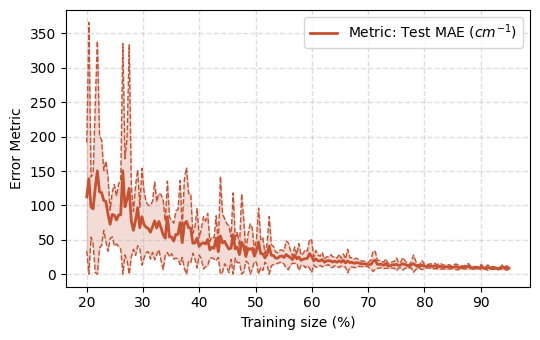

In [37]:
# ----------------------------------------------------------------
# Learning curve showing MAE
# ----------------------------------------------------------------
fig, ax = plot_learning_curve(percs, metrics[:,:,2], metric_label=r'Metric: Test MAE ($cm^{-1}$)')
plt.show()

# 7) Final remarks
In this tutorial we have covered the main analyses performed in the article while going through the code. Despite the whole notebook focuses on MODA, one could similarly produce the same experiments using with SOAP and BoB by substituting `get_MODA()` by the corresponding `get_SOAP()` and `get_BOB()`. Moreover, the reader can either change the dataset used to other TTTA dimers of HT phase and IT phase, or check the results for phenalenyl (PHYL) and Thiele's diradical (THIL). The only modifications reqired to achieve the former changes would consist on setting the correct `couplings_path` and `xyz_path` in the first cell of the notebook.

We have selected TTTA as data source, as it undergoes large changes on its $J_{AB}$ target variable with small structural perturbations. Moreover, it allows to assess the intra/intermolecular separability of the descriptor. However, let us stress that MODA is not fundamentally restricted to $J_{AB}$ predictions nor intermolecular properties. In principle intramolecular properties combined with other target properties (such as transfer integrals, HOMO energy, etc.) can be properly captured by a model trained uppon MODA representation.